# Basic Optimization
In this notebook I'll optimize a trough model to fit the data.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import mars_troughs as mt
%matplotlib inline

In [2]:
print("Creating a trough object.")
test_acc_params = [1e-6]
acc_model_number = 0
test_lag_params = [1]
lag_model_number = 0
errorbar = 100.
tr = mt.Trough(test_acc_params, test_lag_params,
                acc_model_number, lag_model_number,
                errorbar)

Creating a trough object.


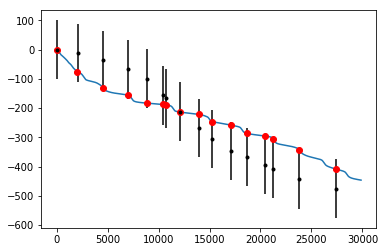

In [3]:
#Compare the trajectory with data
times = tr.ins_times
plt.plot(tr.get_xt(times), tr.get_yt(times))
plt.errorbar(tr.xdata, tr.ydata, yerr=tr.errorbar, c='k', marker='.', ls='')
xn,yn = tr.get_nearest_points()
plt.plot(xn, yn, ls='', marker='o', c='r')

In [4]:
#Define the log likelihood
def ln_likelihood(params):
    variance = params[0]
    if variance < 0:
        return -1e99
    acc_params = np.array([params[1]])
    lag_params = np.array([params[2]])
    tr.set_model(acc_params, lag_params, np.sqrt(variance))
    if any(tr.lags_t < 0) or any(tr.lags_t > 20):
        #print("here")
        #print(tr.lags_t)
        return -1e99
    tr.compute_splines()
    return tr.lnlikelihood()

#And the negative of the log likelihood
def neg_ln_likelihood(params):
    return -ln_likelihood(params)

In [5]:
import scipy.optimize as op
guess = [errorbar**2, test_acc_params[0], test_lag_params[0]]
result = op.minimize(neg_ln_likelihood, x0=guess, method='Nelder-Mead')
print(result)

 final_simplex: (array([[4.08584431e+03, 1.21184416e-06, 1.09796476e+00],
       [4.08584429e+03, 1.21184416e-06, 1.09796477e+00],
       [4.08584425e+03, 1.21184416e-06, 1.09796477e+00],
       [4.08584428e+03, 1.21184416e-06, 1.09796477e+00]]), array([74.52131883, 74.52131883, 74.52131883, 74.52131883]))
           fun: 74.52131882870592
       message: 'Optimization terminated successfully.'
          nfev: 498
           nit: 269
        status: 0
       success: True
             x: array([4.08584431e+03, 1.21184416e-06, 1.09796476e+00])


In [6]:
#Set the model to the best model
best = result['x']
variance = best[0]
acc_params = np.array([best[1]])
lag_params = np.array([best[2]])
tr.set_model(acc_params, lag_params, np.sqrt(variance))

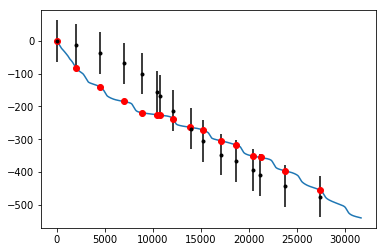

In [7]:
#Compare the trajectory with data
times = tr.ins_times
plt.plot(tr.get_xt(times), tr.get_yt(times))
plt.errorbar(tr.xdata, tr.ydata, yerr=tr.errorbar, c='k', marker='.', ls='')
xn,yn = tr.get_nearest_points()
plt.plot(xn, yn, ls='', marker='o', c='r')

## More complex trough models.
The previous cells used the most basic trough model, with a constant lag $l(t) = l_0$ and an accumulation that is a linear function of the insolation $A(t) = aI(t)$. The next most complicated models can either make the lag linear in time or making the accumulation quadratic in insolation: $l(t) = l_0 + l_1t$ and $A(t) = aI + bI^2$.

In [14]:
print("Creating a trough object.")
test_acc_params = [1e-6]
acc_model_number = 0
test_lag_params = [1, 1e-6]
lag_model_number = 1
errorbar = 100.
tr2 = mt.Trough(test_acc_params, test_lag_params,
                acc_model_number, lag_model_number,
                errorbar)

Creating a trough object.


In [15]:
#Define the log likelihood
def ln_likelihood2(params):
    variance = params[0]
    if variance < 0:
        return -1e99
    acc_params = np.array([params[1]])
    lag_params = np.array([params[2:4]])
    tr2.set_model(acc_params, lag_params, np.sqrt(variance))
    if any(tr2.lags_t < 0) or any(tr2.lags_t > 20):
        #print("here")
        #print(tr.lags_t)
        return -1e99
    tr2.compute_splines()
    return tr2.lnlikelihood()

#And the negative of the log likelihood
def neg_ln_likelihood2(params):
    return -ln_likelihood2(params)

In [16]:
guess = [errorbar**2, test_acc_params[0], 
         test_lag_params[0], test_lag_params[1]]
result = op.minimize(neg_ln_likelihood2, x0=guess, method='Nelder-Mead')
print(result)

AssertionError: New and original lag parameters must have the same shape.